In [4]:
# Corrected script with drop syntax fixed for Pandas DataFrame.drop

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────────────────────────────────────
# Fixed categorical map for Inputs 1–8
# ────────────────────────────────────────────────────────────────────────────────
categories_map = {
    'Input 1': [1, 2],
    'Input 2': list(range(1, 6)),     # 1–5
    'Input 3': list(range(1, 6)),     # 1–5
    'Input 4': list(range(1, 22)),    # 1–21
    'Input 5': list(range(1, 6)),     # 1–5
    'Input 6': [1, 2, 3],
    'Input 7': [1, 2, 3, 4],
    'Input 8': list(range(1, 11)),    # 1–10
}

# ────────────────────────────────────────────────────────────────────────────────
# Fixed list of real‐valued inputs for normalization (Inputs 9–18)
# ────────────────────────────────────────────────────────────────────────────────
numeric_inputs = [f"Input {i}" for i in range(9, 19)]

def cross_validate_with_history(
    csv_path, use_inputs, k_folds,
    layer_dims, activations, epochs,
    lr, batch_size, device, random_state
):
    df = pd.read_csv(csv_path)
    # drop F2/F3 if present
    for dropcol in ('F2','F3'):
        if dropcol in df.columns:
            df = df.drop(columns=[dropcol])

    # select & mask
    all_in = [f"Input {i}" for i in range(1,19)]
    selected = [c for c,u in zip(all_in, use_inputs) if u]
    X = df[selected].copy()
    # target
    y_np = df['Output'].to_numpy(dtype=np.float32).reshape(-1,1)
    y_mean, y_std = y_np.mean(), (y_np.std() if y_np.std()!=0 else 1.0)
    y = (y_np - y_mean)/y_std

    # encode 1–8
    for col, cats in categories_map.items():
        if col not in X.columns:
            continue
        if len(cats) == 2:
            X[col] = X[col].map({cats[0]: +1.0, cats[1]: -1.0})
        else:
            X[col] = pd.Categorical(X[col], categories=cats)
            dummies = pd.get_dummies(X[col], prefix=col)
            for c in cats:
                name = f"{col}_{c}"
                if name not in dummies.columns:
                    dummies[name] = 0
            X = pd.concat([X.drop(columns=[col]), dummies], axis=1)

    # normalize 9–18
    means, stds = X[numeric_inputs].mean(), X[numeric_inputs].std().replace(0,1.0)
    X[numeric_inputs] = (X[numeric_inputs] - means) / stds

    X_np = X.to_numpy(dtype=np.float32)

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    folds = []
    histories = []

    for fold, (tr, va) in enumerate(kf.split(X_np), 1):
        X_tr, X_va = X_np[tr], X_np[va]
        y_tr, y_va = y[tr],    y[va]

        ds_tr = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
        ds_va = TensorDataset(torch.from_numpy(X_va), torch.from_numpy(y_va))
        ld_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True)
        ld_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False)

        # build model
        layers = []
        dim_in = X_tr.shape[1]
        for dim, act in zip(layer_dims, activations):
            layers.append(nn.Linear(dim_in, dim))
            a = act.lower()
            if a == 'relu':
                layers.append(nn.ReLU())
            elif a == 'tanh':
                layers.append(nn.Tanh())
            elif a == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif a == 'softplus':
                layers.append(nn.Softplus())
            else:
                raise ValueError(f"Unsupported activation: {act}")
            dim_in = dim
        layers.append(nn.Linear(dim_in, 1))
        model = nn.Sequential(*layers).to(device)

        opt = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        train_losses, val_losses = [], []
        for ep in range(1, epochs+1):
            model.train()
            for xb, yb in ld_tr:
                xb, yb = xb.to(device), yb.to(device)
                opt.zero_grad()
                loss_fn(model(xb), yb).backward()
                opt.step()
            model.eval()
            with torch.no_grad():
                p_tr = model(torch.from_numpy(X_tr).to(device)).cpu().numpy()
                p_va = model(torch.from_numpy(X_va).to(device)).cpu().numpy()
            train_losses.append(mean_squared_error(y_tr, p_tr))
            val_losses.append(mean_squared_error(y_va, p_va))

        folds.append({
            'fold': fold,
            'train_preds': p_tr.flatten(),
            'train_true': y_tr.flatten(),
            'val_preds': p_va.flatten(),
            'val_true': y_va.flatten(),
        })
        histories.append((train_losses, val_losses))

    return folds, histories, (y_mean, y_std), X.columns.tolist()


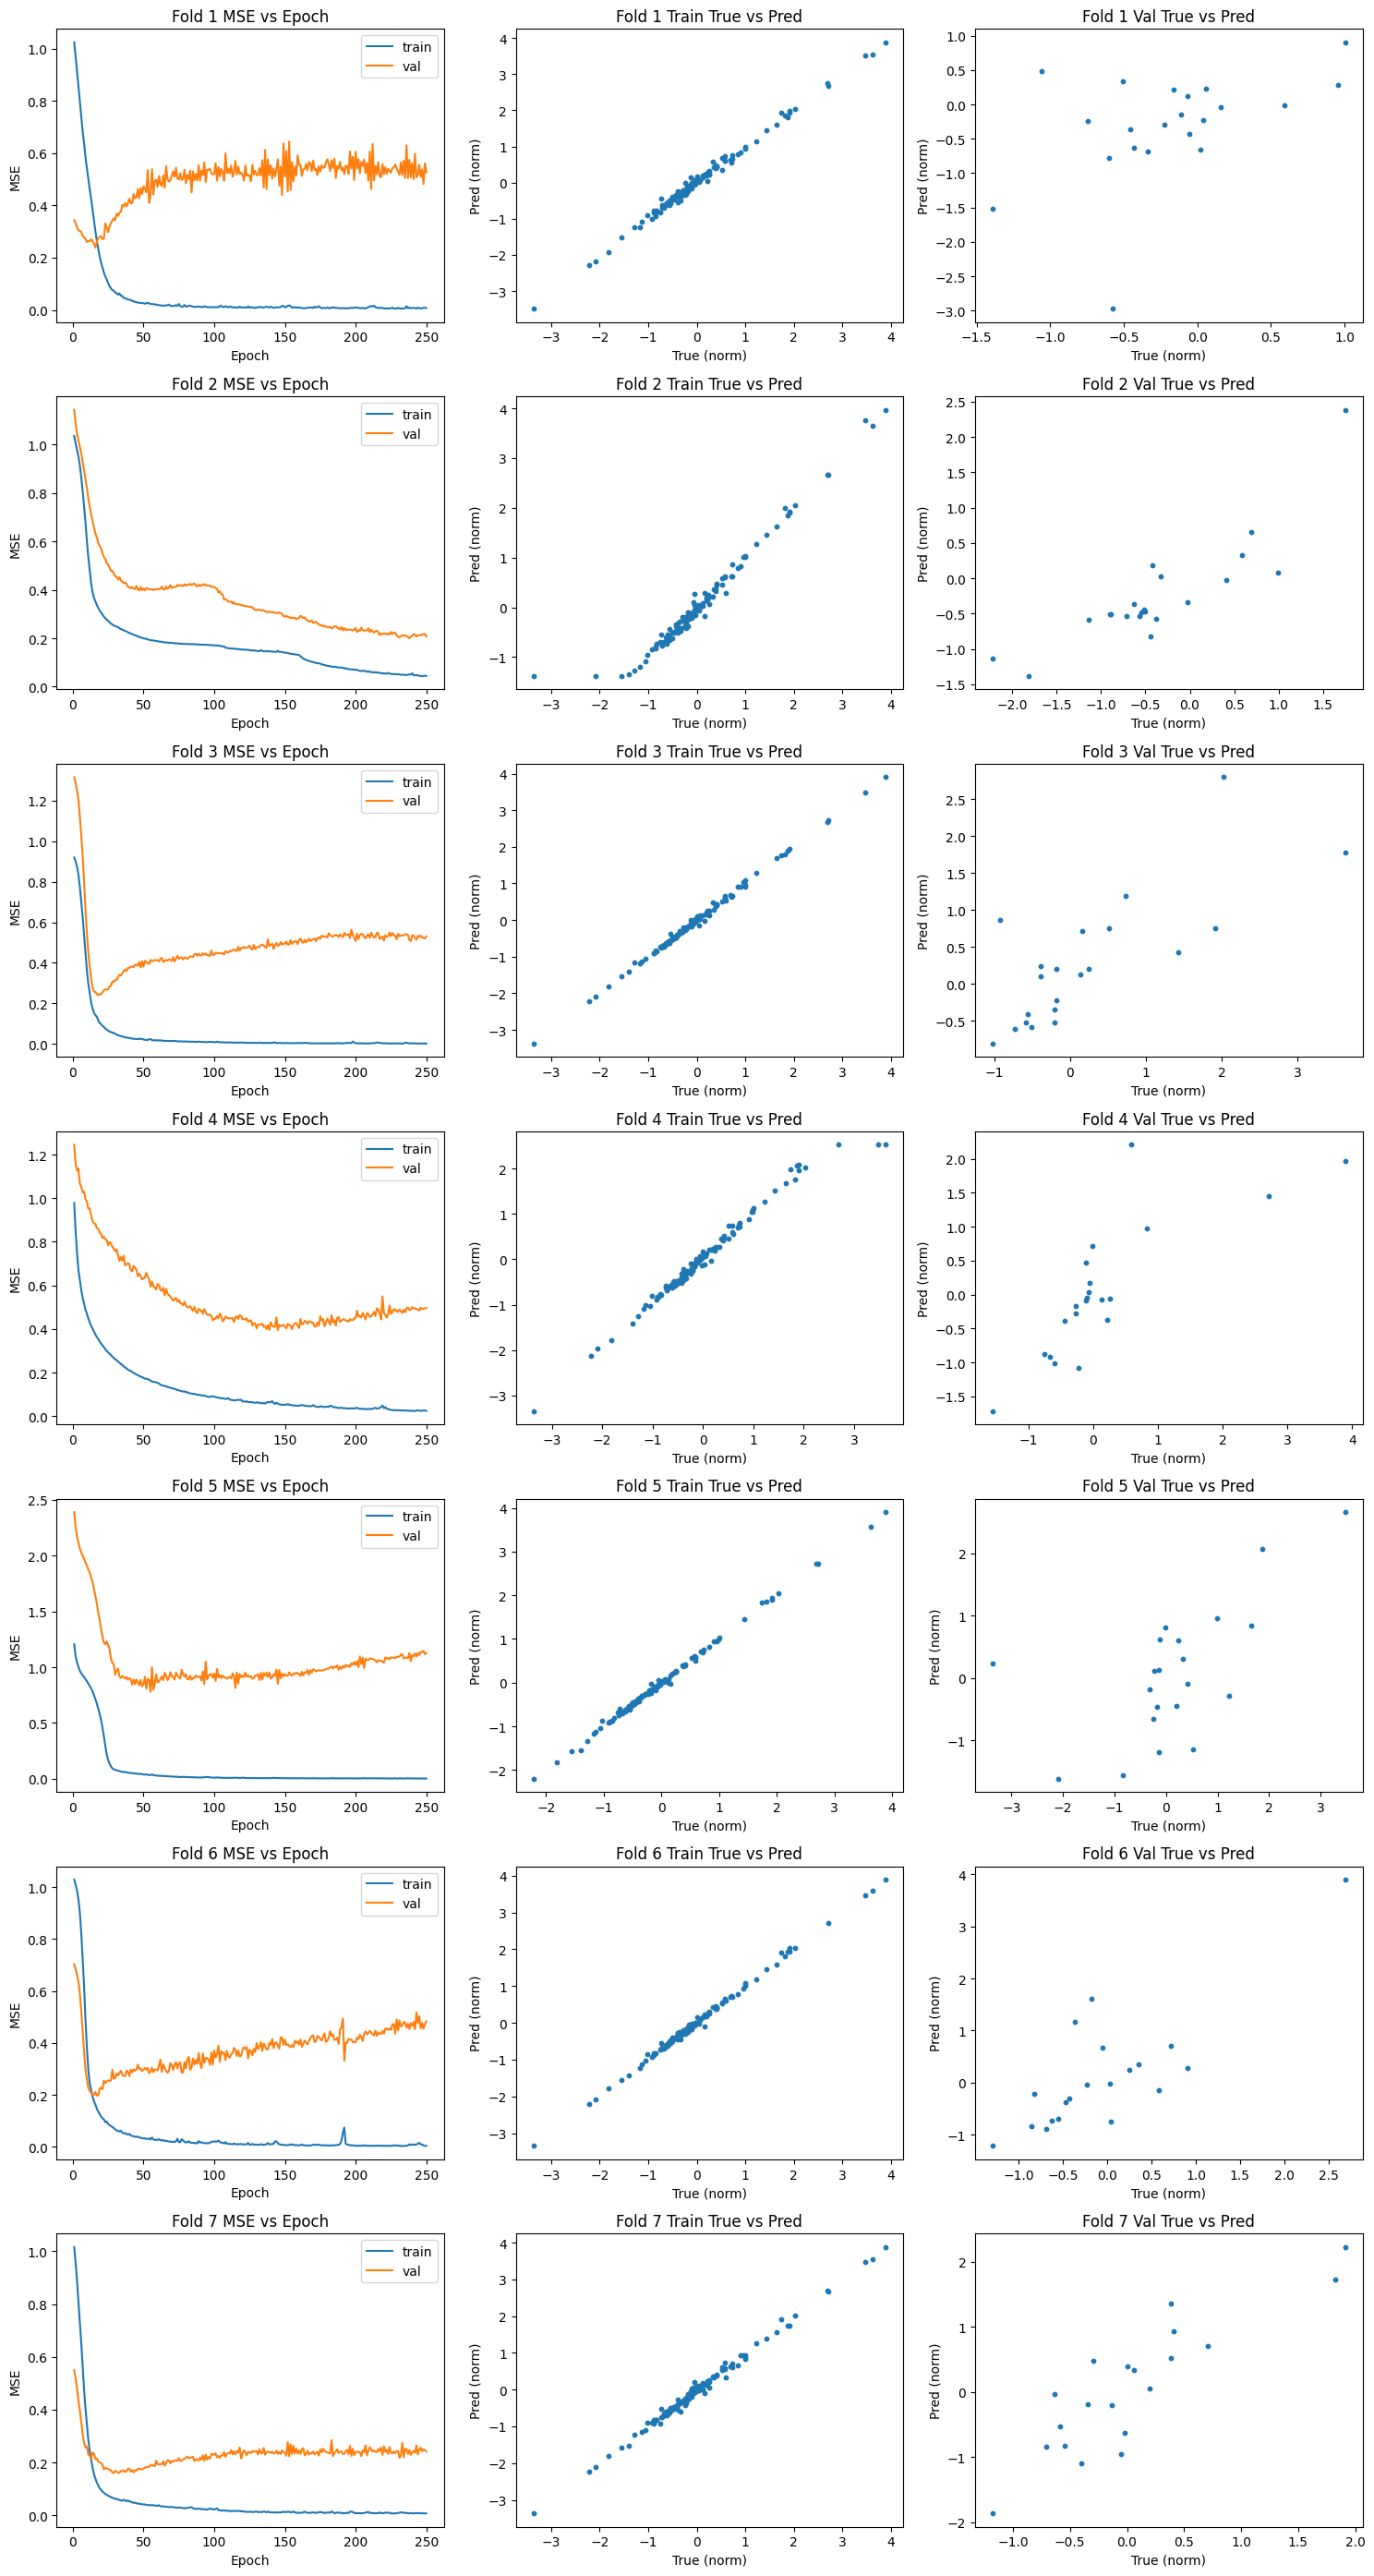

In [5]:
use_inputs  = [True] * 18
k_folds     = 7
layer_dims  = [8, 4]
activations = ['relu', 'relu']
epochs      = 250
lr          = 2e-3
batch_size  = 8
device      = 'cpu'
csv_path    = '/home/kamiar/chevron/Acid-neural-net/First Data-V2/data/Cleanded_data_nn(SampleData_07032025_vf3).csv'
rs          = 42

folds, histories, (y_m, y_s), feat_names = cross_validate_with_history(
    csv_path, use_inputs, k_folds,
    layer_dims, activations, epochs,
    lr, batch_size, device, rs
)

# Plot
fig, axes = plt.subplots(k_folds, 3, figsize=(15, 4*k_folds))
for i, (f, hist) in enumerate(zip(folds, histories)):
    tr_loss, va_loss = hist
    ax1, ax2, ax3 = axes[i]
    # MSE vs Epoch
    ax1.plot(range(1, epochs+1), tr_loss, label='train')
    ax1.plot(range(1, epochs+1), va_loss, label='val')
    ax1.set_title(f'Fold {f["fold"]} MSE vs Epoch')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('MSE'); ax1.legend()
    # Train scatter
    ax2.scatter(f['train_true'], f['train_preds'], s=10)
    ax2.set_title(f'Fold {f["fold"]} Train True vs Pred')
    ax2.set_xlabel('True (norm)'); ax2.set_ylabel('Pred (norm)')
    # Val scatter
    ax3.scatter(f['val_true'], f['val_preds'], s=10)
    ax3.set_title(f'Fold {f["fold"]} Val True vs Pred')
    ax3.set_xlabel('True (norm)'); ax3.set_ylabel('Pred (norm)')
plt.tight_layout()
plt.show()


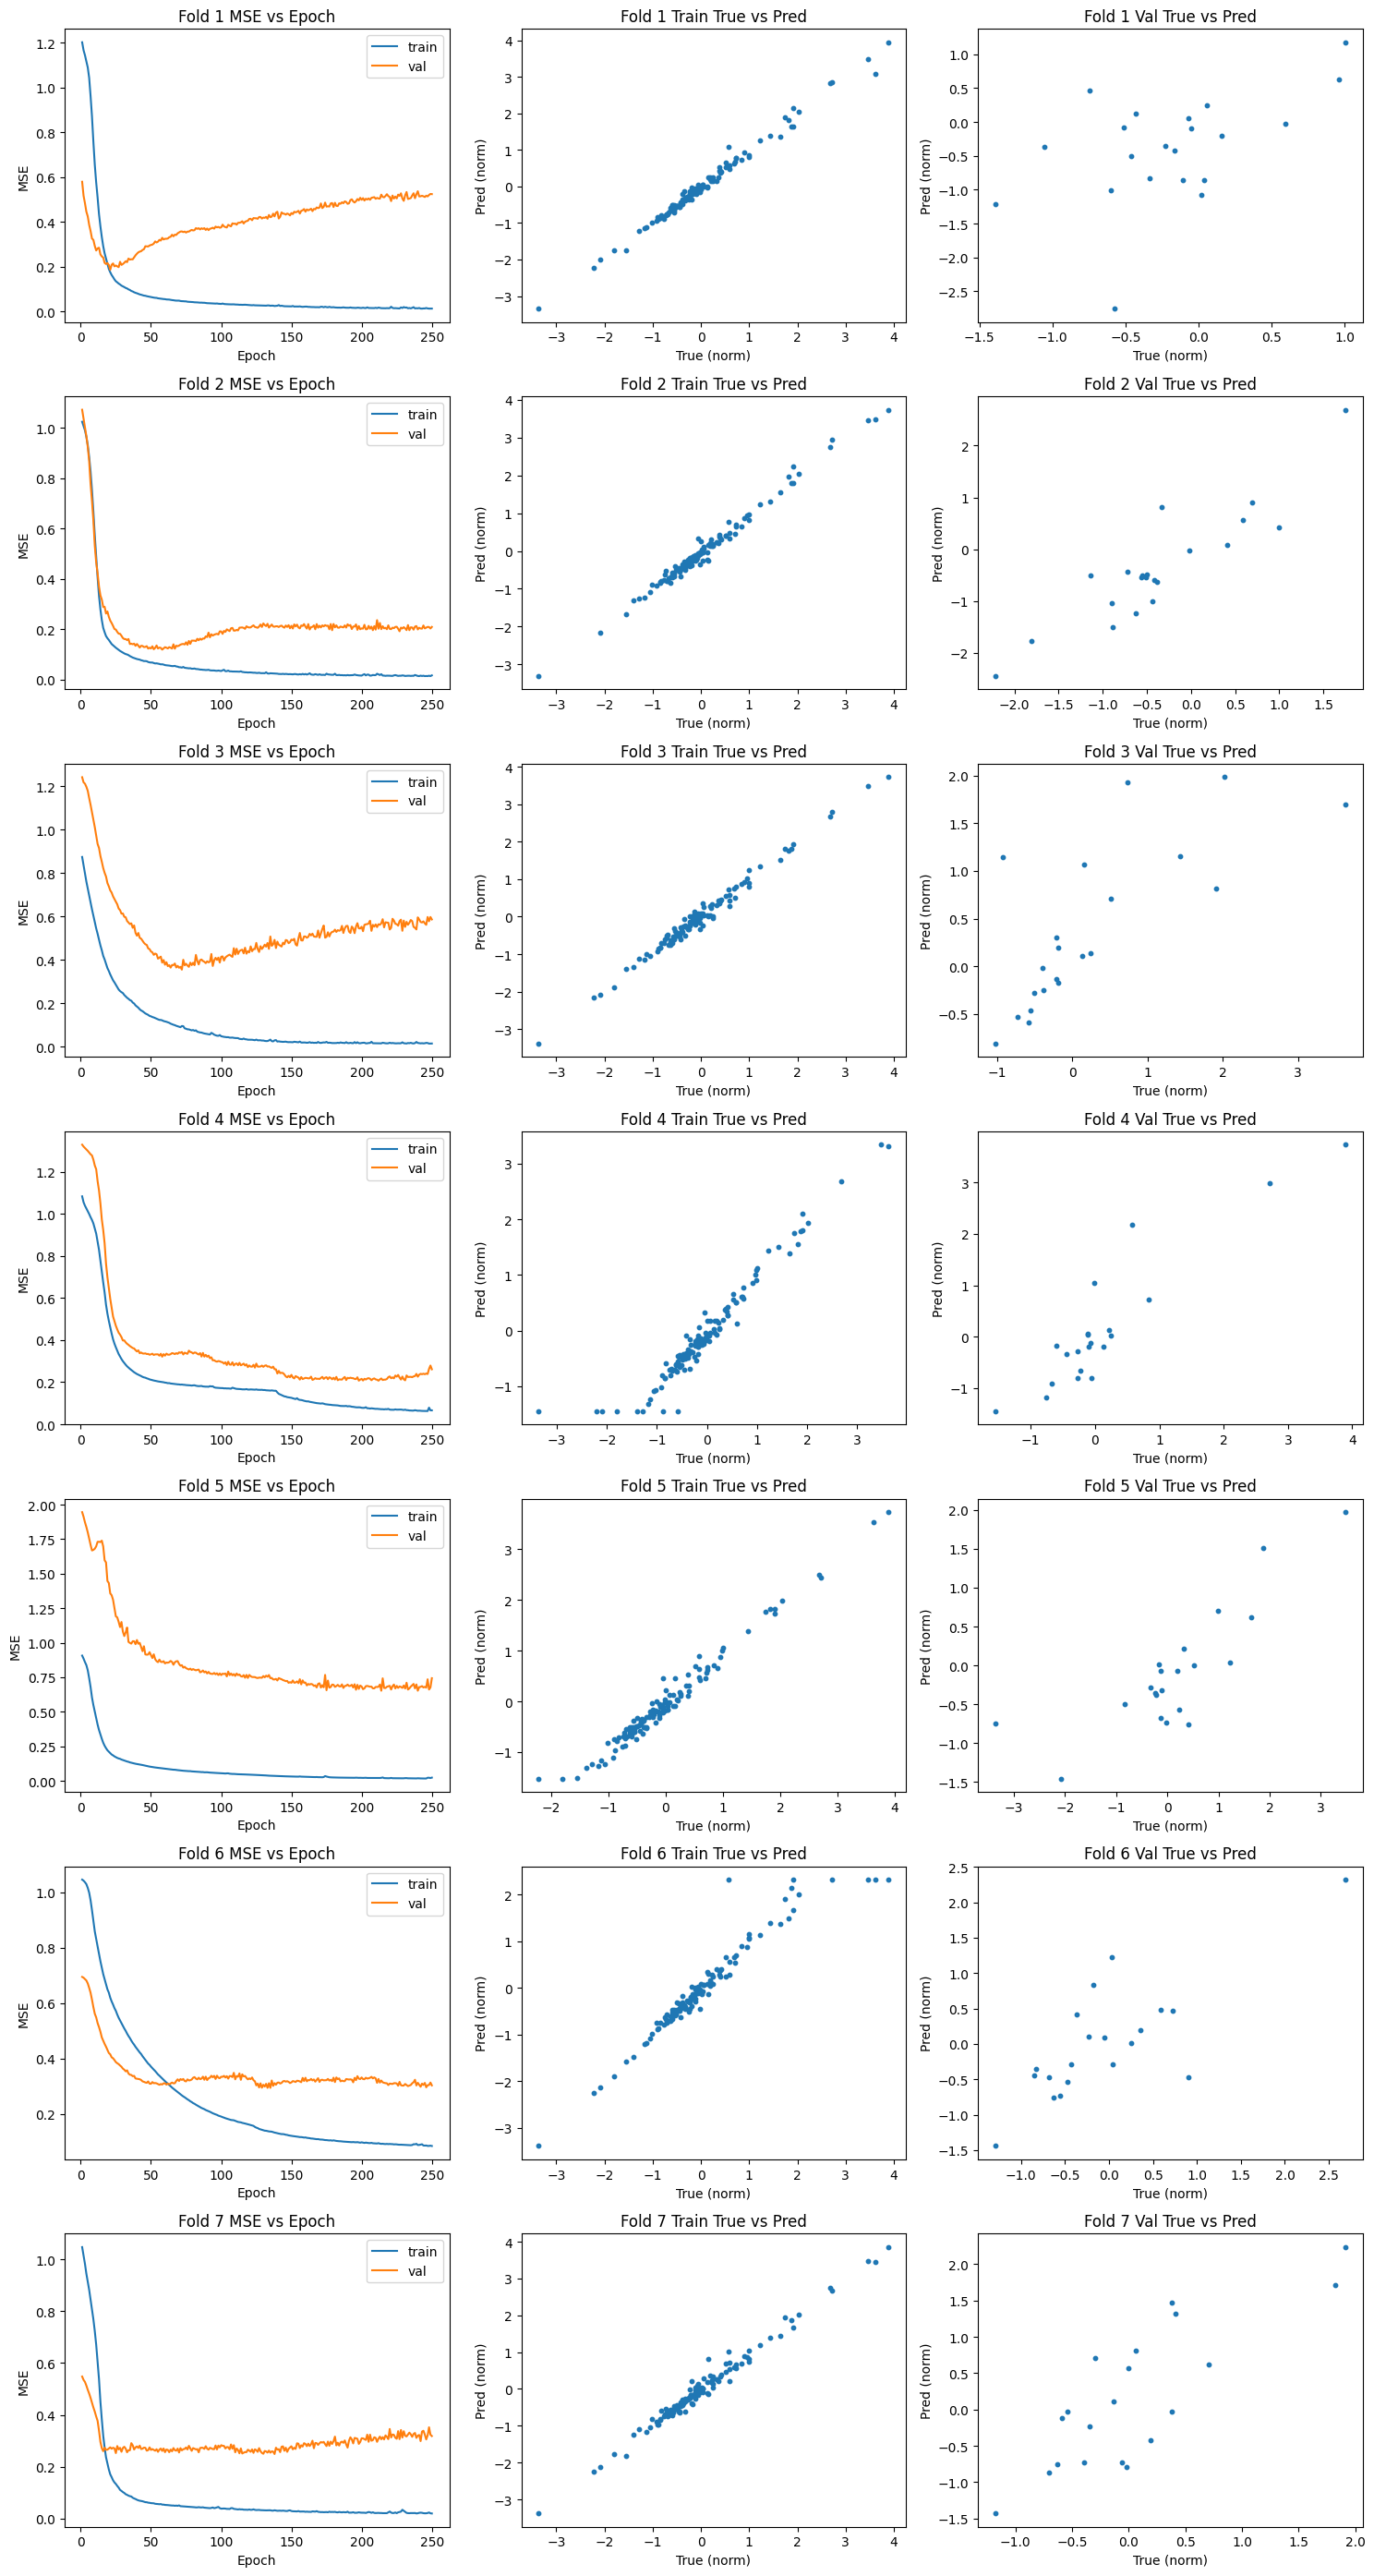

In [6]:
use_inputs  = [True] * 18
k_folds     = 7
layer_dims  = [4, 4]
activations = ['relu', 'relu']
epochs      = 250
lr          = 2e-3
batch_size  = 8
device      = 'cpu'
csv_path    = '/home/kamiar/chevron/Acid-neural-net/First Data-V2/data/Cleanded_data_nn(SampleData_07032025_vf3).csv'
rs          = 42

folds, histories, (y_m, y_s), feat_names = cross_validate_with_history(
    csv_path, use_inputs, k_folds,
    layer_dims, activations, epochs,
    lr, batch_size, device, rs
)

# Plot
fig, axes = plt.subplots(k_folds, 3, figsize=(15, 4*k_folds))
for i, (f, hist) in enumerate(zip(folds, histories)):
    tr_loss, va_loss = hist
    ax1, ax2, ax3 = axes[i]
    # MSE vs Epoch
    ax1.plot(range(1, epochs+1), tr_loss, label='train')
    ax1.plot(range(1, epochs+1), va_loss, label='val')
    ax1.set_title(f'Fold {f["fold"]} MSE vs Epoch')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('MSE'); ax1.legend()
    # Train scatter
    ax2.scatter(f['train_true'], f['train_preds'], s=10)
    ax2.set_title(f'Fold {f["fold"]} Train True vs Pred')
    ax2.set_xlabel('True (norm)'); ax2.set_ylabel('Pred (norm)')
    # Val scatter
    ax3.scatter(f['val_true'], f['val_preds'], s=10)
    ax3.set_title(f'Fold {f["fold"]} Val True vs Pred')
    ax3.set_xlabel('True (norm)'); ax3.set_ylabel('Pred (norm)')
plt.tight_layout()
plt.show()


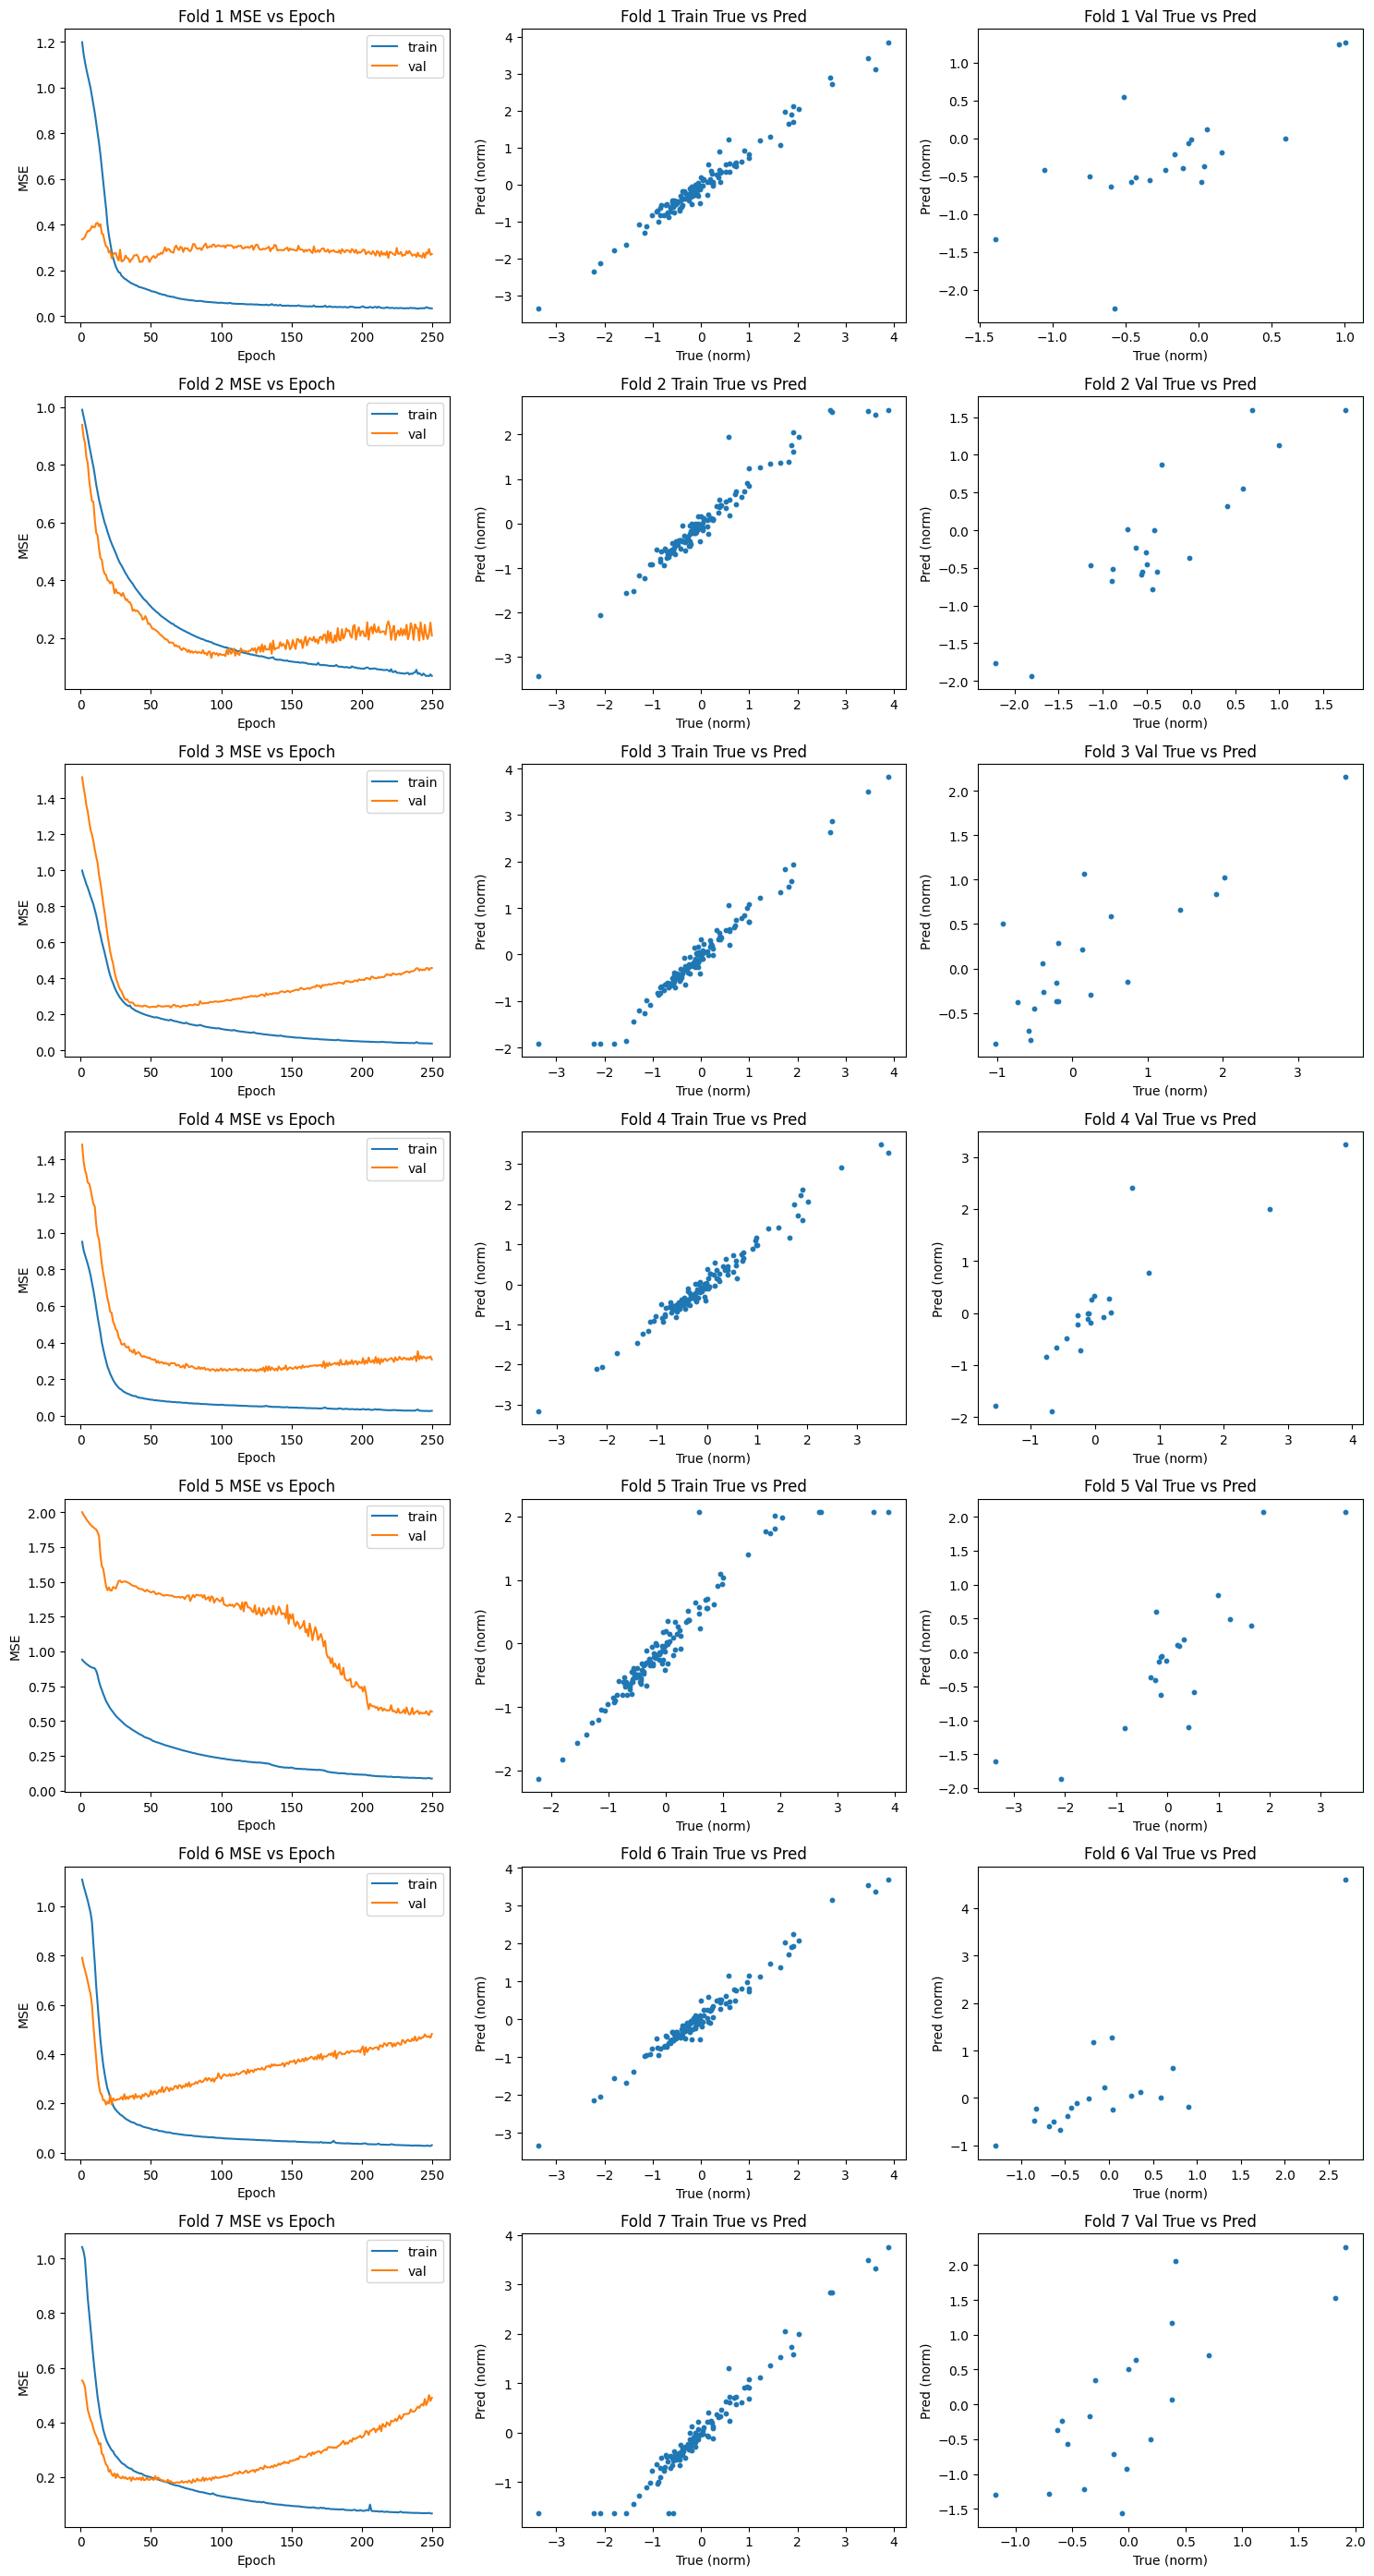

In [7]:
use_inputs  = [True] * 18
k_folds     = 7
layer_dims  = [4, 4]
activations = ['Softplus', 'relu']
epochs      = 250
lr          = 2e-3
batch_size  = 8
device      = 'cpu'
csv_path    = '/home/kamiar/chevron/Acid-neural-net/First Data-V2/data/Cleanded_data_nn(SampleData_07032025_vf3).csv'
rs          = 42

folds, histories, (y_m, y_s), feat_names = cross_validate_with_history(
    csv_path, use_inputs, k_folds,
    layer_dims, activations, epochs,
    lr, batch_size, device, rs
)

# Plot
fig, axes = plt.subplots(k_folds, 3, figsize=(15, 4*k_folds))
for i, (f, hist) in enumerate(zip(folds, histories)):
    tr_loss, va_loss = hist
    ax1, ax2, ax3 = axes[i]
    # MSE vs Epoch
    ax1.plot(range(1, epochs+1), tr_loss, label='train')
    ax1.plot(range(1, epochs+1), va_loss, label='val')
    ax1.set_title(f'Fold {f["fold"]} MSE vs Epoch')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('MSE'); ax1.legend()
    # Train scatter
    ax2.scatter(f['train_true'], f['train_preds'], s=10)
    ax2.set_title(f'Fold {f["fold"]} Train True vs Pred')
    ax2.set_xlabel('True (norm)'); ax2.set_ylabel('Pred (norm)')
    # Val scatter
    ax3.scatter(f['val_true'], f['val_preds'], s=10)
    ax3.set_title(f'Fold {f["fold"]} Val True vs Pred')
    ax3.set_xlabel('True (norm)'); ax3.set_ylabel('Pred (norm)')
plt.tight_layout()
plt.show()


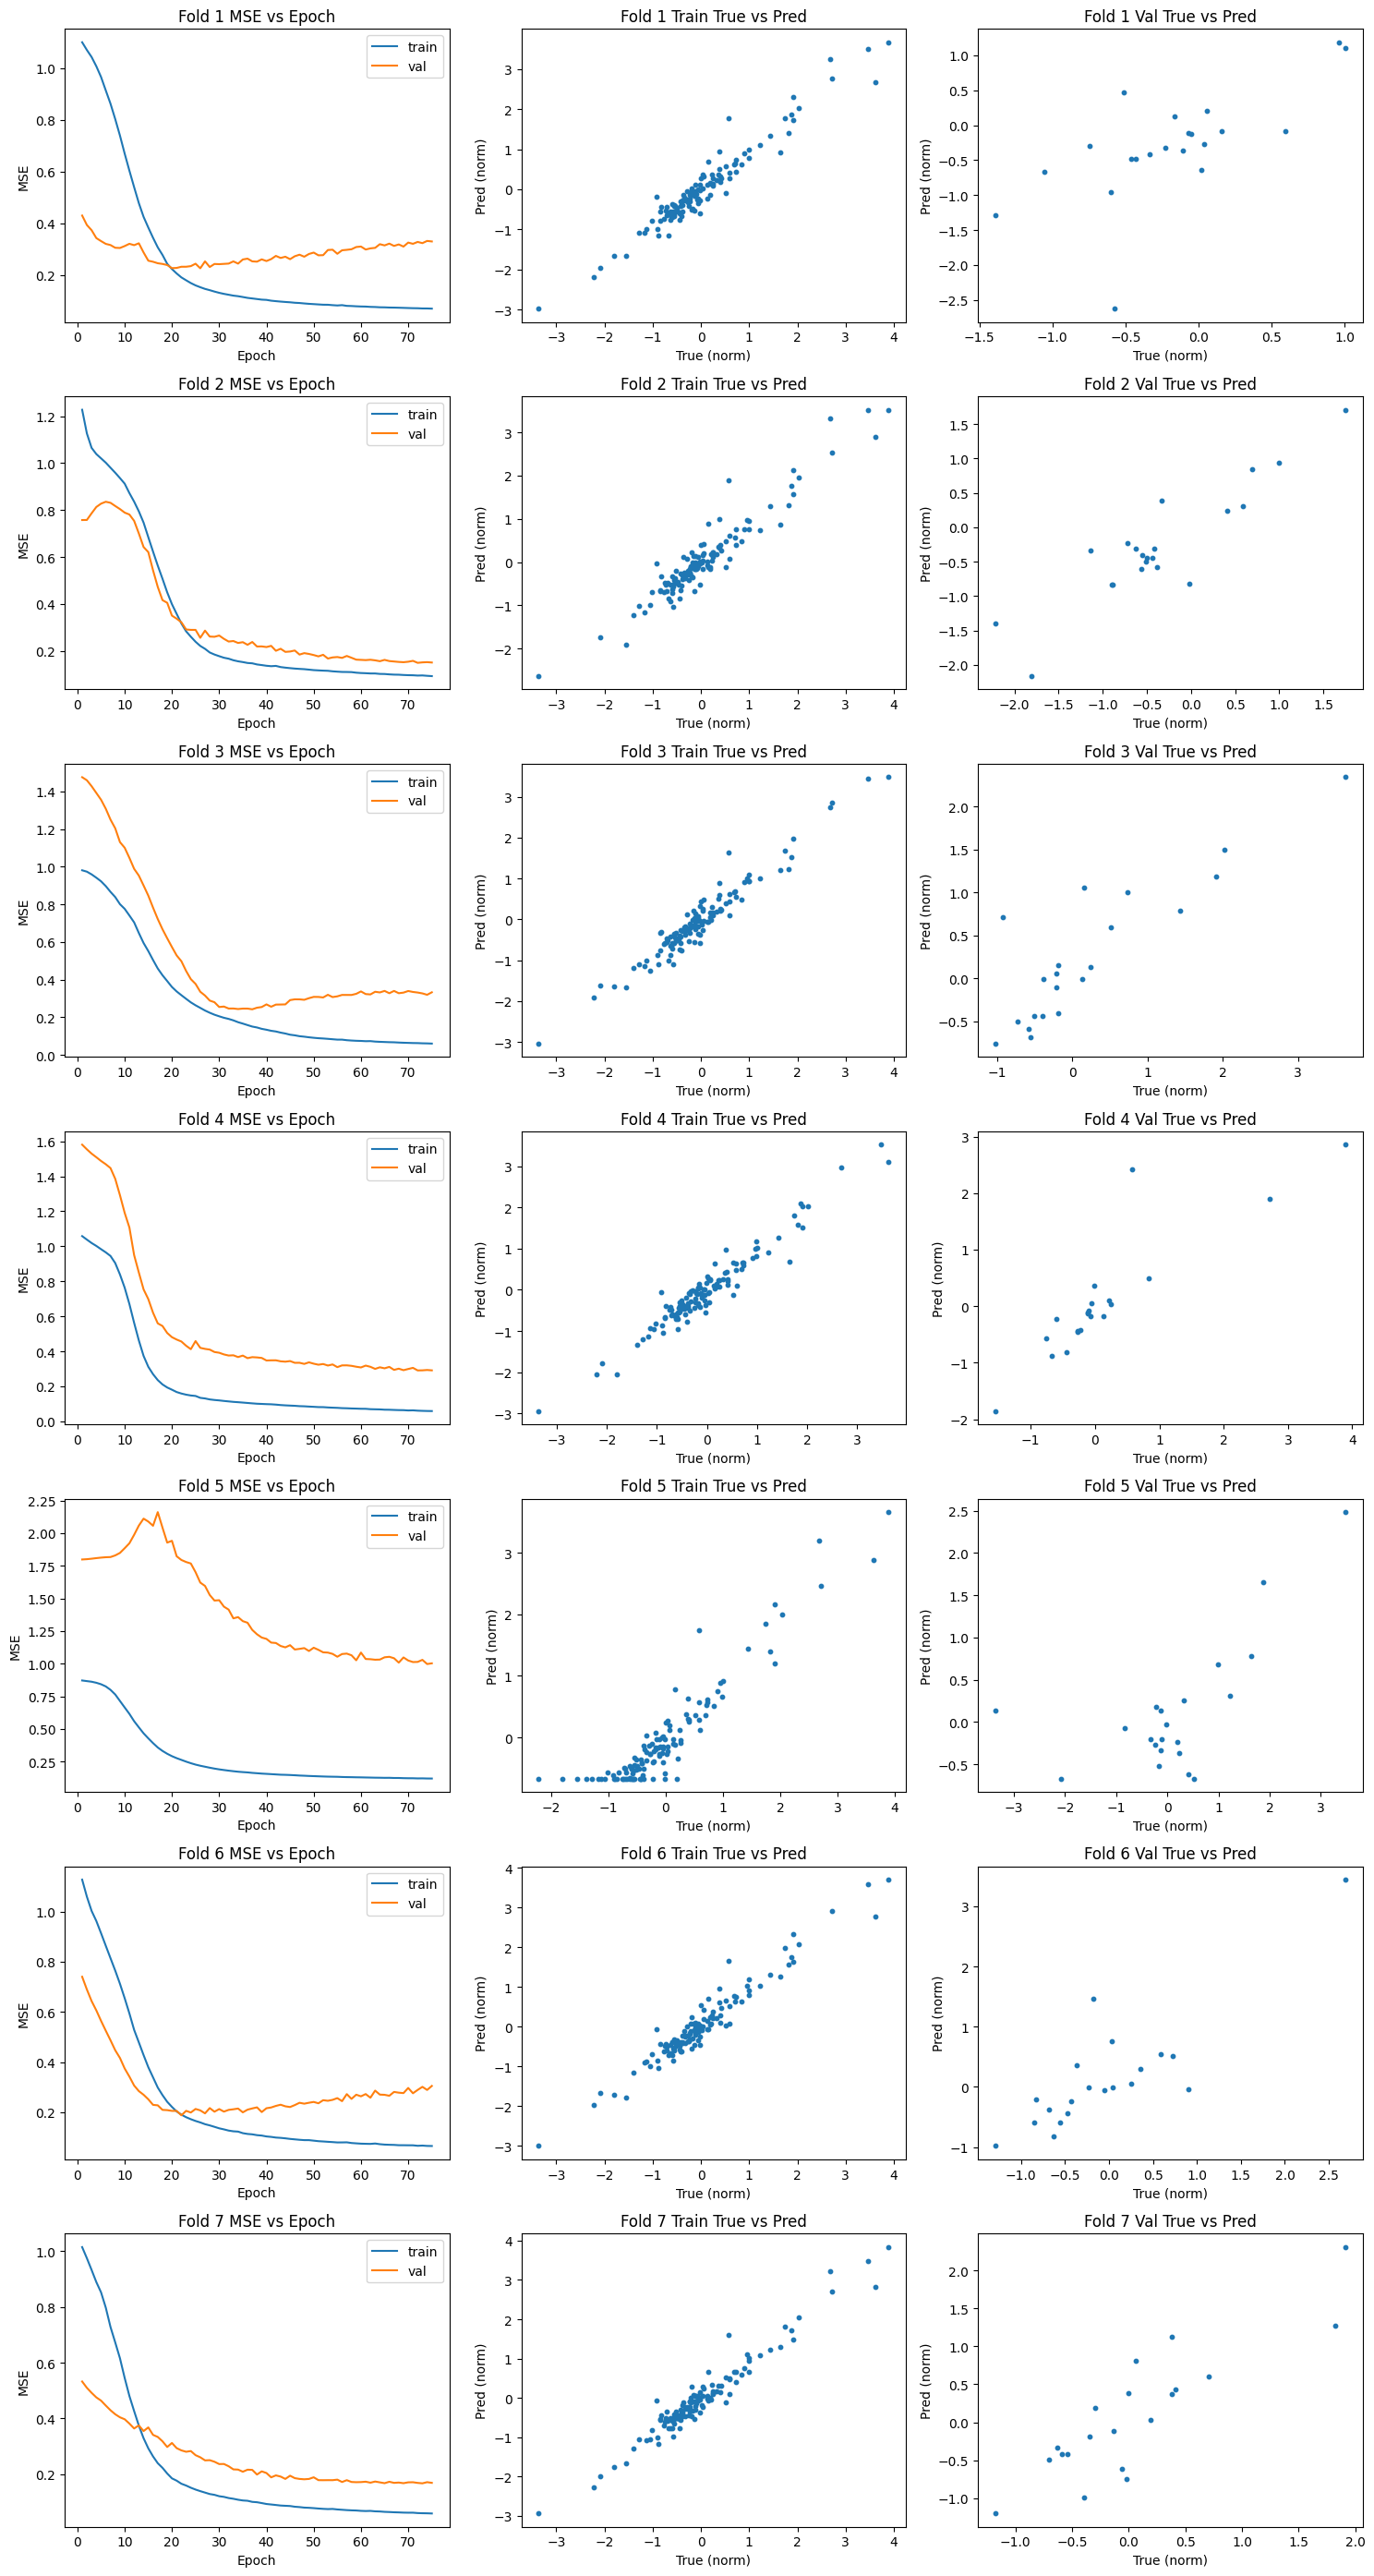

In [10]:
use_inputs  = [True] * 18
k_folds     = 7
layer_dims  = [4, 4]
activations = ['Softplus', 'relu']
epochs      = 75
lr          = 2e-3
batch_size  = 8
device      = 'cpu'
csv_path    = '/home/kamiar/chevron/Acid-neural-net/First Data-V2/data/Cleanded_data_nn(SampleData_07032025_vf3).csv'
rs          = 42

folds, histories, (y_m, y_s), feat_names = cross_validate_with_history(
    csv_path, use_inputs, k_folds,
    layer_dims, activations, epochs,
    lr, batch_size, device, rs
)

# Plot
fig, axes = plt.subplots(k_folds, 3, figsize=(15, 4*k_folds))
for i, (f, hist) in enumerate(zip(folds, histories)):
    tr_loss, va_loss = hist
    ax1, ax2, ax3 = axes[i]
    # MSE vs Epoch
    ax1.plot(range(1, epochs+1), tr_loss, label='train')
    ax1.plot(range(1, epochs+1), va_loss, label='val')
    ax1.set_title(f'Fold {f["fold"]} MSE vs Epoch')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('MSE'); ax1.legend()
    # Train scatter
    ax2.scatter(f['train_true'], f['train_preds'], s=10)
    ax2.set_title(f'Fold {f["fold"]} Train True vs Pred')
    ax2.set_xlabel('True (norm)'); ax2.set_ylabel('Pred (norm)')
    # Val scatter
    ax3.scatter(f['val_true'], f['val_preds'], s=10)
    ax3.set_title(f'Fold {f["fold"]} Val True vs Pred')
    ax3.set_xlabel('True (norm)'); ax3.set_ylabel('Pred (norm)')
plt.tight_layout()
plt.show()


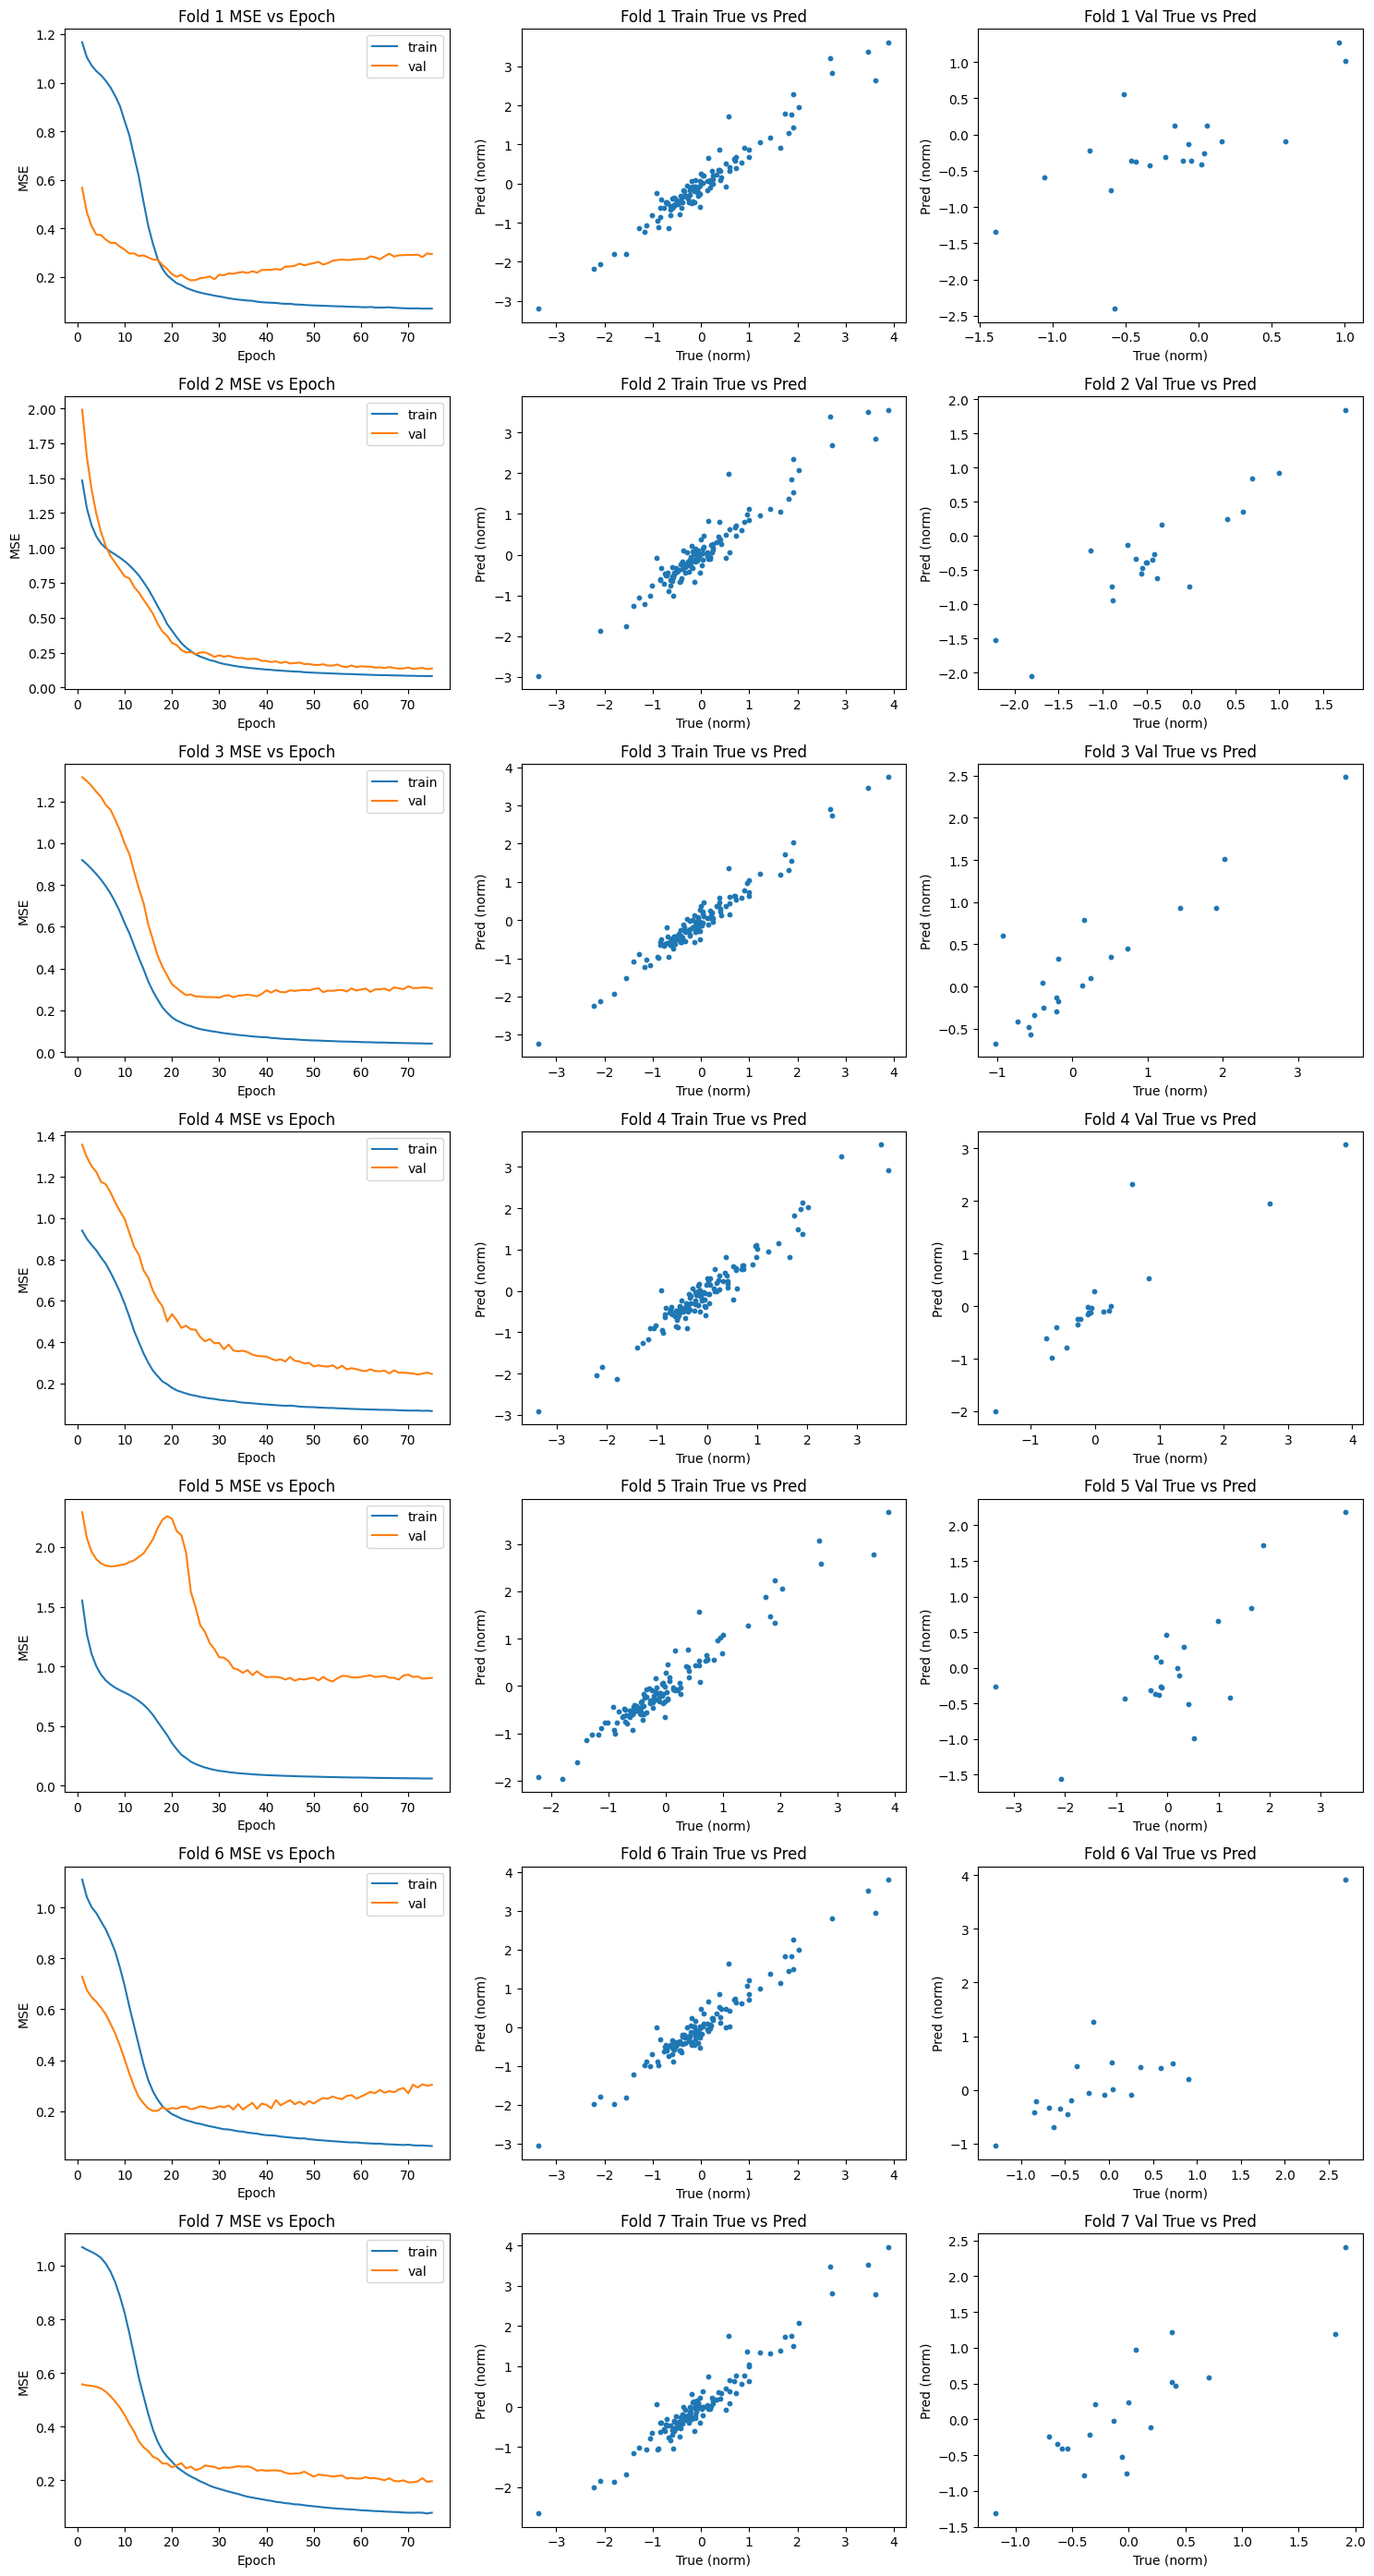

In [11]:
use_inputs  = [True] * 18
k_folds     = 7
layer_dims  = [4, 4]
activations = ['Softplus', 'Softplus']
epochs      = 75
lr          = 2e-3
batch_size  = 8
device      = 'cpu'
csv_path    = '/home/kamiar/chevron/Acid-neural-net/First Data-V2/data/Cleanded_data_nn(SampleData_07032025_vf3).csv'
rs          = 42

folds, histories, (y_m, y_s), feat_names = cross_validate_with_history(
    csv_path, use_inputs, k_folds,
    layer_dims, activations, epochs,
    lr, batch_size, device, rs
)

# Plot
fig, axes = plt.subplots(k_folds, 3, figsize=(15, 4*k_folds))
for i, (f, hist) in enumerate(zip(folds, histories)):
    tr_loss, va_loss = hist
    ax1, ax2, ax3 = axes[i]
    # MSE vs Epoch
    ax1.plot(range(1, epochs+1), tr_loss, label='train')
    ax1.plot(range(1, epochs+1), va_loss, label='val')
    ax1.set_title(f'Fold {f["fold"]} MSE vs Epoch')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('MSE'); ax1.legend()
    # Train scatter
    ax2.scatter(f['train_true'], f['train_preds'], s=10)
    ax2.set_title(f'Fold {f["fold"]} Train True vs Pred')
    ax2.set_xlabel('True (norm)'); ax2.set_ylabel('Pred (norm)')
    # Val scatter
    ax3.scatter(f['val_true'], f['val_preds'], s=10)
    ax3.set_title(f'Fold {f["fold"]} Val True vs Pred')
    ax3.set_xlabel('True (norm)'); ax3.set_ylabel('Pred (norm)')
plt.tight_layout()
plt.show()


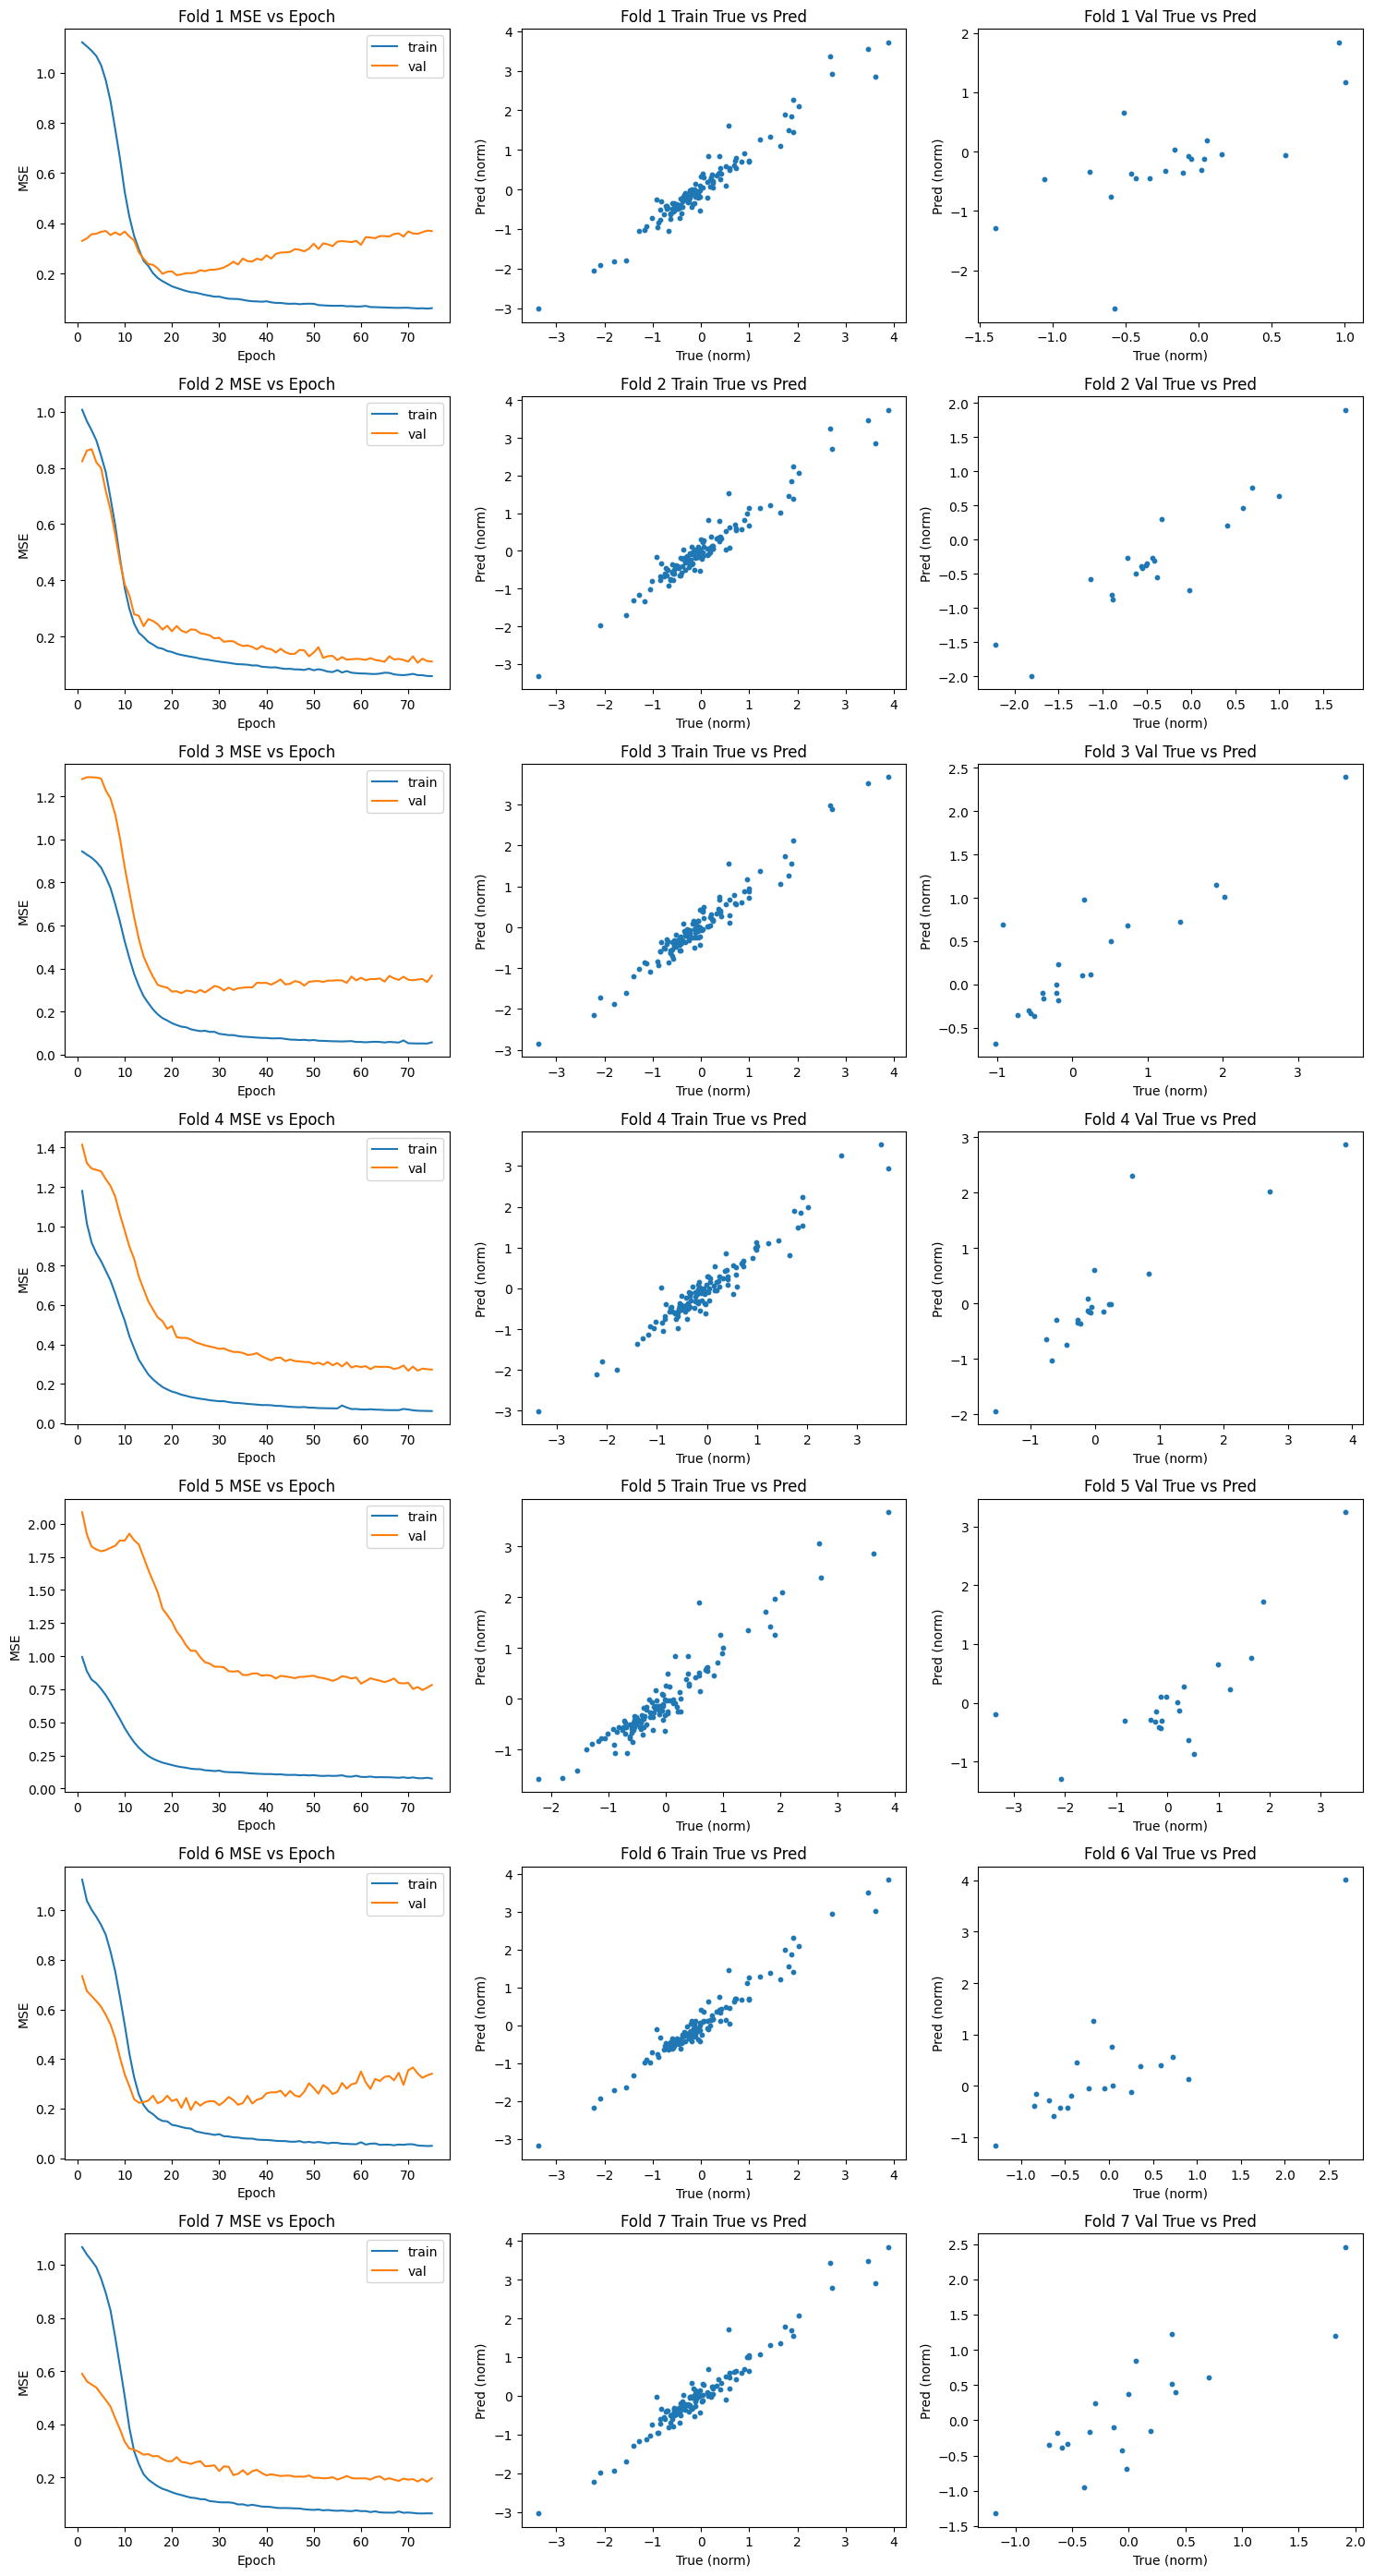

In [15]:
use_inputs  = [True] * 18
k_folds     = 7
layer_dims  = [4, 4]
activations = ['Softplus', 'Softplus']
epochs      = 75
lr          = 2e-3
batch_size  = 4
device      = 'cpu'
csv_path    = '/home/kamiar/chevron/Acid-neural-net/First Data-V2/data/Cleanded_data_nn(SampleData_07032025_vf3).csv'
rs          = 42

folds, histories, (y_m, y_s), feat_names = cross_validate_with_history(
    csv_path, use_inputs, k_folds,
    layer_dims, activations, epochs,
    lr, batch_size, device, rs
)

# Plot
fig, axes = plt.subplots(k_folds, 3, figsize=(15, 4*k_folds))
for i, (f, hist) in enumerate(zip(folds, histories)):
    tr_loss, va_loss = hist
    ax1, ax2, ax3 = axes[i]
    # MSE vs Epoch
    ax1.plot(range(1, epochs+1), tr_loss, label='train')
    ax1.plot(range(1, epochs+1), va_loss, label='val')
    ax1.set_title(f'Fold {f["fold"]} MSE vs Epoch')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('MSE'); ax1.legend()
    # Train scatter
    ax2.scatter(f['train_true'], f['train_preds'], s=10)
    ax2.set_title(f'Fold {f["fold"]} Train True vs Pred')
    ax2.set_xlabel('True (norm)'); ax2.set_ylabel('Pred (norm)')
    # Val scatter
    ax3.scatter(f['val_true'], f['val_preds'], s=10)
    ax3.set_title(f'Fold {f["fold"]} Val True vs Pred')
    ax3.set_xlabel('True (norm)'); ax3.set_ylabel('Pred (norm)')
plt.tight_layout()
plt.show()
